In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 9.5MB/s 
     |████████████████████████████████| 204kB 20.4MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 1.2MB 20.2MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '4fad8655fa7244f2999cc19cea71afb1')

In [5]:
search_images_bing

<function fastbook.search_images_bing>

In [6]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [8]:
import os
os.mkdir('images')

In [9]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

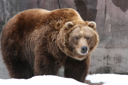

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

In [11]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [12]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [13]:
fns = get_image_files(path)
fns

(#402) [Path('bears/teddy/00000050.jpg'),Path('bears/teddy/00000067.jpg'),Path('bears/teddy/00000009.jpg'),Path('bears/teddy/00000080.jpg'),Path('bears/teddy/00000055.jpg'),Path('bears/teddy/00000118.jpg'),Path('bears/teddy/00000044.jpg'),Path('bears/teddy/00000129.jpg'),Path('bears/teddy/00000093.jpg'),Path('bears/teddy/00000113.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#5) [Path('bears/teddy/00000105.jpg'),Path('bears/black/00000084.jpg'),Path('bears/black/00000026.jpg'),Path('bears/grizzly/00000105.jpg'),Path('bears/grizzly/00000011.jpg')]

In [15]:
failed.map(Path.unlink);

In [17]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)) # will resize by squishing or stretching

In [20]:
??DataBlock

In [19]:
# dataloaders has a validation and training dataloader. 
# it provides data in batches to the GPU
dls = bears.dataloaders(path)

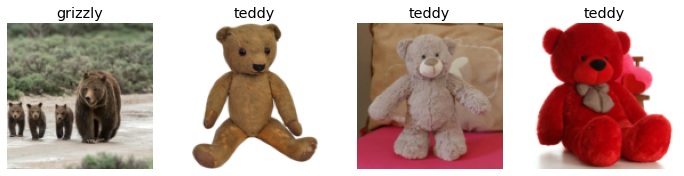

In [21]:
# default cropping method has loss of data
dls.valid.show_batch(max_n=4, nrows=1)

In [23]:
??bears.new

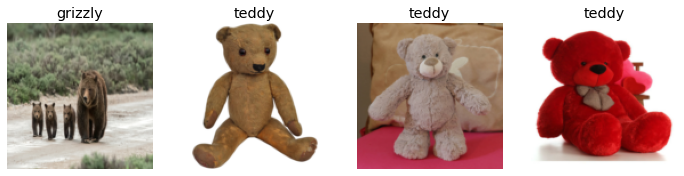

In [22]:
# squish method
# efficient, but neural nets have to learn that image is squished
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

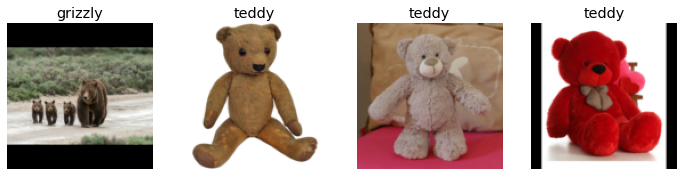

In [24]:
# cleanest method, wasted pixels and computation
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

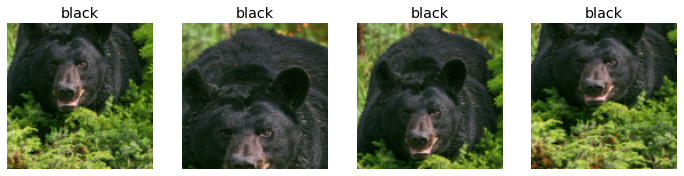

In [25]:
# most common approach, grabs different part of the image and zooms into it. 
# worst of all methods. much less likely to overfit because of seeing different images everytime.
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

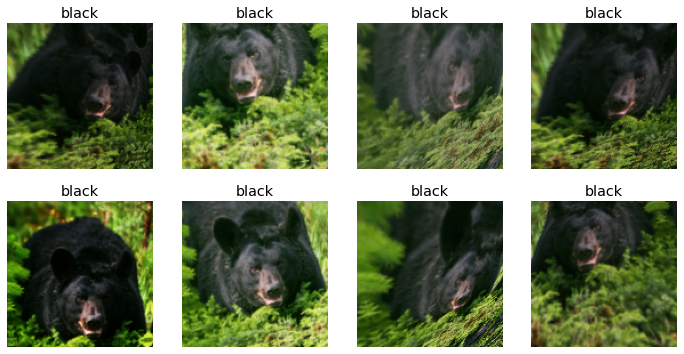

In [26]:
# aug_transforms returns list of different augumentations of both batch and image trfms
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [27]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [28]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

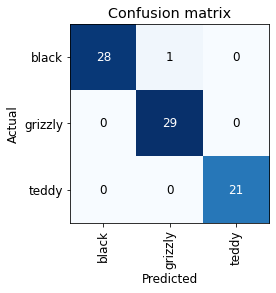

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

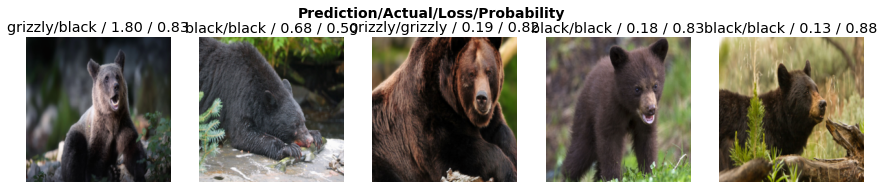

In [30]:
interp.plot_top_losses(5, nrows=1)

In [31]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [32]:
learn.export()

In [33]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [34]:
learn_inf = load_learner(path/'export.pkl')

In [35]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([5.0711e-05, 9.9990e-01, 4.9195e-05]))

In [36]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [37]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [38]:
img = PILImage.create(btn_upload.data[-1])

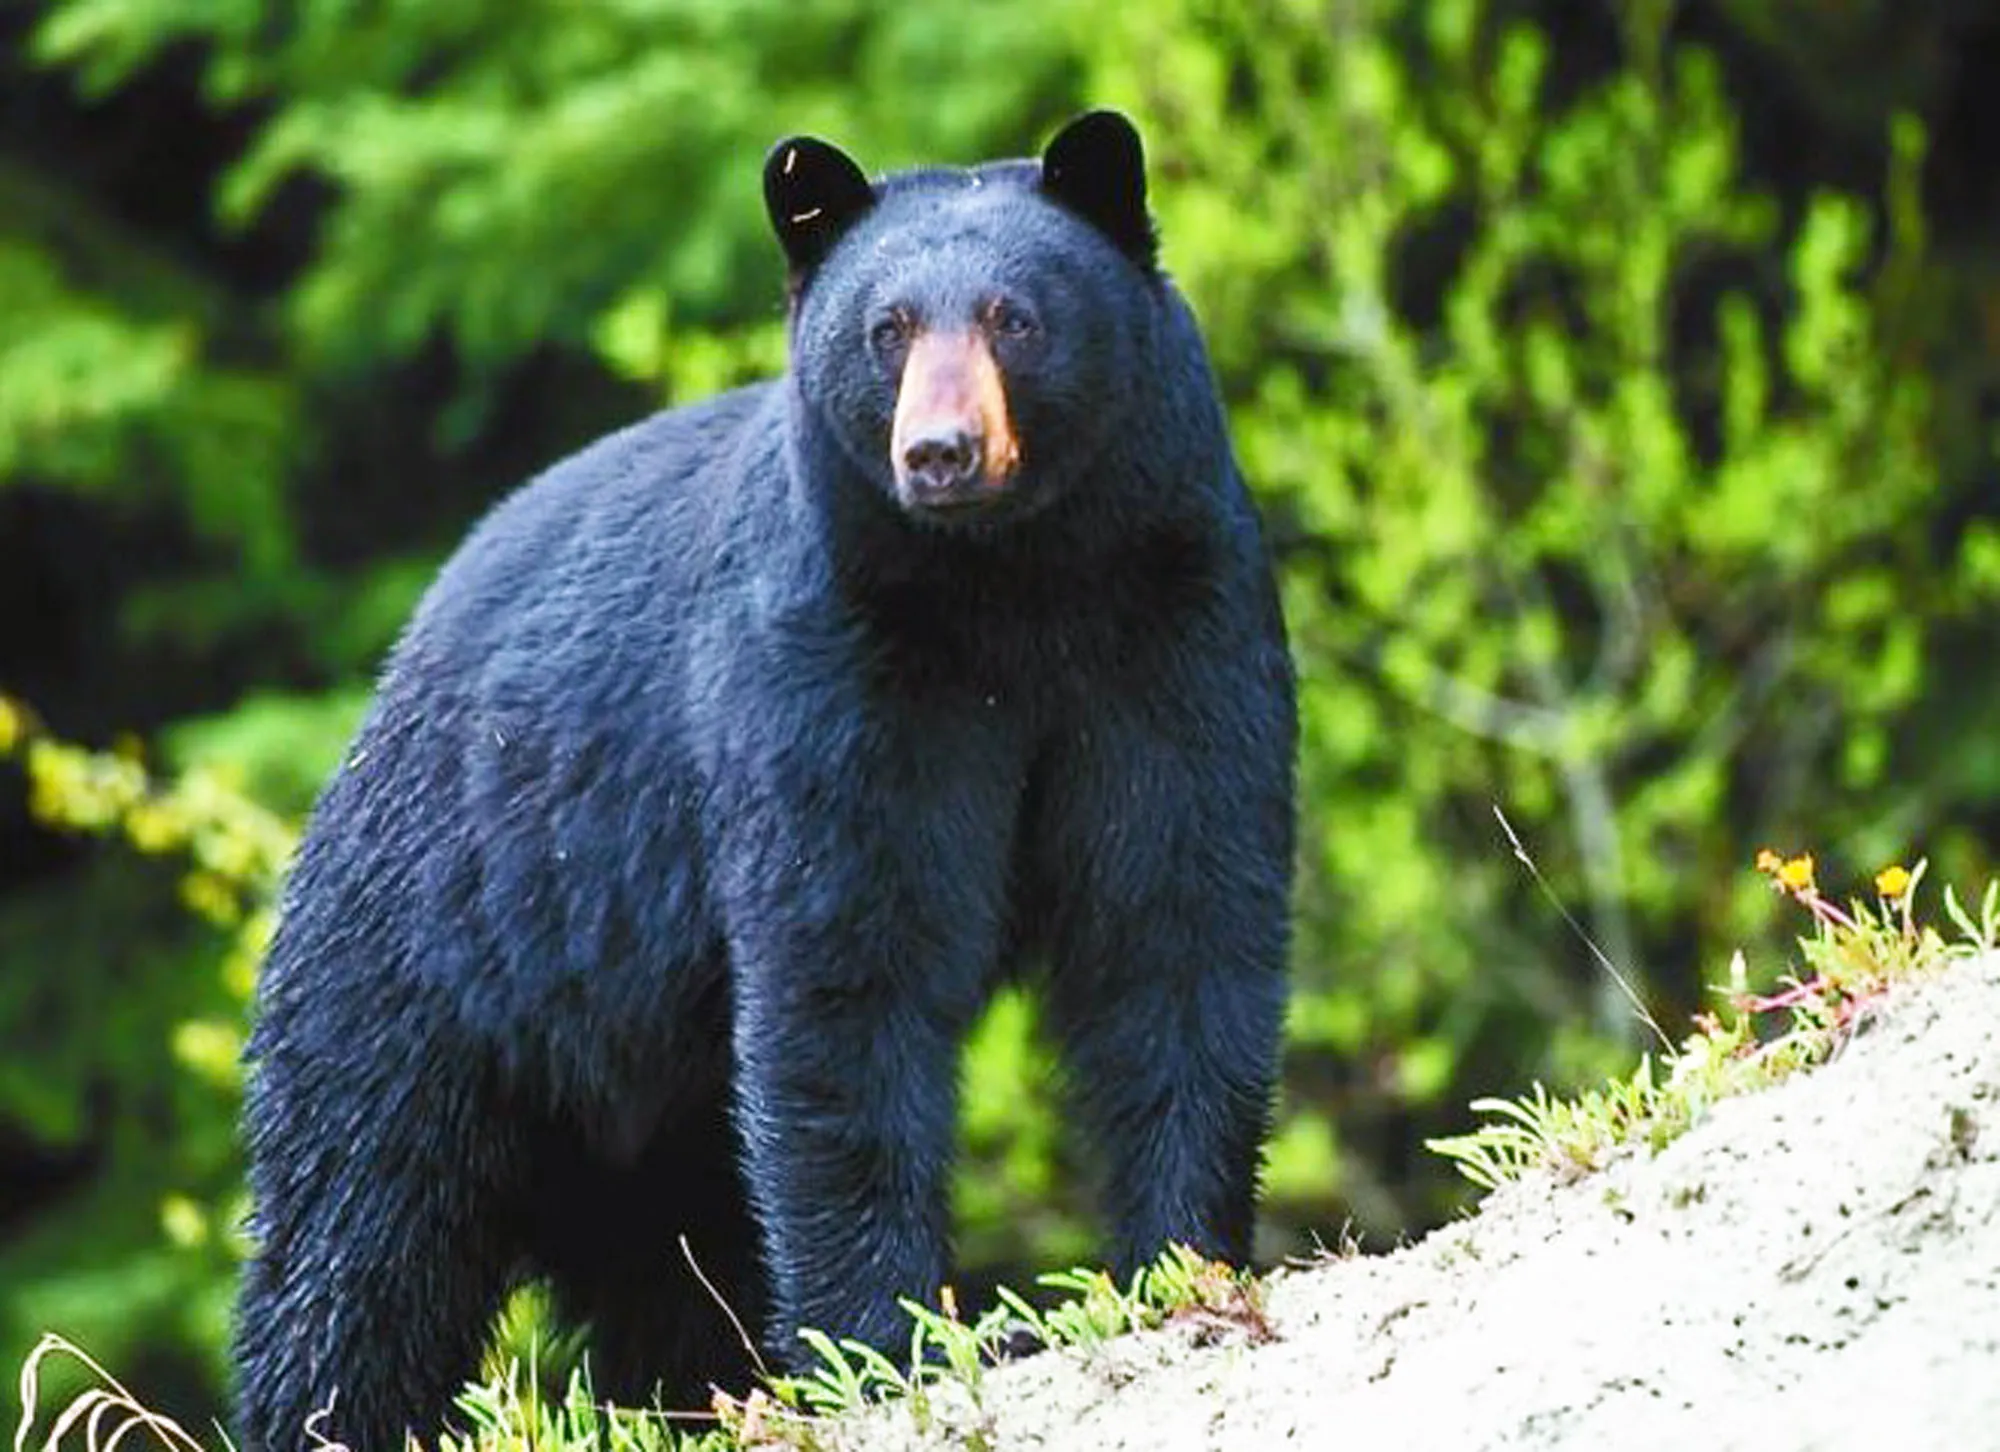

In [39]:
img

In [48]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [49]:
pred,pred_idx,probs = learn_inf.predict(img)

In [50]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: black; Probability: 0.9998')

In [51]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [52]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [53]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [54]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 